<img style="float: left;padding: 1.3em" src="https://indico.phys.sinica.edu.tw/event/74/attachments/246/623/KIW-10.png" width="50%">  

# Core-Collapse Supernova Waveforms

### GW data workshop @ KIW-10

This tutorial describes how we convert the simulated CCSN waveforms into the `TimeSeries` data in `gwpy`.
Once we have the `TimeSeries` waveform, we could use the analysis that we have learned in eariler tutorials.

## Software Setup

We will use the `igwn-py39-lw` enviroment from the [odw-2023](https://github.com/gw-odw/odw-2023/blob/main/setup.md).

### Option 1: Google Colab

Folow the instruction [here](https://github.com/gw-odw/odw-2023/blob/main/setup.md#option-1-google-colab).

### Option 2: Use Conda

Follow the instruction [here](https://github.com/gw-odw/odw-2023/blob/main/setup.md#option-3-you-have-a-linux-or-applemac-computer----use-conda). 

## Initialization

Run the below cell to import necessary packages in this tutorial.\
If you got any errors, please make sure that you have prepared the necessary software enviroment as decribed in the above cells.

In [1]:
import gwpy
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.interpolate import interp1d
from gwpy.timeseries import TimeSeries

In [2]:
%matplotlib inline

# Wavefrom Pre-processing

### CCSN simulations

In `./Data_GW`, there are CCSN waveforms from Pan et al. ([2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...857...13P/abstract), [2021](https://ui.adsabs.harvard.edu/abs/2021ApJ...914..140P/abstract)).

| Waveform  | Progenitor Mass | Dimension  | EoS | Viewing angle | File name | other notes |
|---|---|---|---|---|---|---|
| $h_\times$ | 40 | 2 | BHB$\Lambda\phi$ | Equator | `data_s40_2d_BHBlp_d2_CrossEquator.d` |
| $h_\times$ | 40 | 2 | DD2 | Equator | `data_s40_2d_DD2_d2_CrossEquator.d` |
| $h_\times$ | 40 | 2 | LS220 | Equator | `data_s40_2d_LS220_d2_CrossEquator.d` |
| $h_\times$ | 40 | 2 | SFHo | Equator | `data_s40_2d_SFHo_d2_CrossEquator.d` |
| $h_\times$ | 40 | 3 | LS220 | Equator | `data_s40_fr_d3_CrossEquator.d` | Fast rotation |
| $h_+$ | 40 | 3 | LS220 | Equator | `data_s40_fr_d3_PlusEquator.d` | Fast rotation |
| $h_\times$ | 40 | 3 | LS220 | Pole | `data_s40_fr_d3_CrossPole.d` | Fast rotation |
| $h_+$ | 40 | 3 | LS220 | Pole | `data_s40_fr_d3_PlusPole.d` | Fast rotation |
| $h_\times$ | 40 | 3 | LS220 | Equator | `data_s40_sr_d3_CrossEquator.d` | Slow rotation |
| $h_+$ | 40 | 3 | LS220 | Equator | `data_s40_sr_d3_PlusEquator.d` | Slow rotation |
| $h_\times$ | 40 | 3 | LS220 | Pole | `data_s40_sr_d3_CrossPole.d` | Slow rotation |
| $h_+$ | 40 | 3 | LS220 | Pole | `data_s40_sr_d3_PlusPole.d` | Slow rotation |
| $h_\times$ | 40 | 3 | LS220 | Equator | `data_s40_nor_d3_CrossEquator.d` | No rotation |
| $h_+$ | 40 | 3 | LS220 | Equator | `data_s40_nor_d3_PlusEquator.d` | No rotation |
| $h_\times$ | 40 | 3 | LS220 | Pole | `data_s40_nor_d3_CrossPole.d` | No rotation |
| $h_+$ | 40 | 3 | LS220 | Pole | `data_s40_nor_d3_PlusPole.d` | No rotation |

### Load the simulated waveforms

Unlike binary black hole mergers, there is no simple waveform generators for CCSNe.\
All the waveforms require multi-dimensional numerical simulations of CCSN (or using seismology). 

Therefore, we need to preprcoess the simulated waveforms before we could use it. 

In [3]:
# preview the data
#
# Here is a waveform template generated from a 2D CCSN simulation using a 40 solar mass progenitor with LS220 EoS.
#
!head -n 20 ./Data_GW/data_s40_2d_LS220_d2_CrossEquator.d

#  ---------------------------------------------------------------------------------------------------------------------------------------------
#  Model   : data_s40_2d_LS220_d2_CrossEquator
#    
#  Created by Kuo-Chuan Pan
#    Date: 10/11/2020
#    Time: 12:39:42
#    
#  ---------------------------------------------------------------------------------------------------------------------------------------------
#    Time [s]        Strain []       
  -4.6633778e-01  1.9643971e-23  
  -4.6597386e-01  1.9631371e-23  
  -4.6510188e-01  1.9619404e-23  
  -4.6423148e-01  1.9622556e-23  
  -4.6336258e-01  1.9651062e-23  
  -4.6249441e-01  1.9689864e-23  
  -4.6162658e-01  1.9734090e-23  
  -4.6075962e-01  1.9791318e-23  
  -4.5989347e-01  1.9856945e-23  
  -4.5902750e-01  1.9923346e-23  
  -4.5816099e-01  1.9996748e-23  


Use `numpy.loadtxt()` to load the waveform.

In [4]:
file_name = "./Data_GW/data_s40_2d_LS220_d2_CrossEquator.d"
db = np.loadtxt(file_name, unpack=True)
times_raw  = db[0] # the raw time series
strain_raw = db[1] # the raw strains

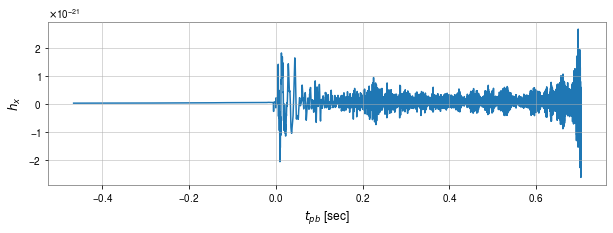

In [5]:
plt.figure(figsize=(10,3))
plt.plot(times_raw, strain_raw)
plt.xlabel(r"$t_{pb}$ [sec]")
plt.ylabel(r"$h_x$")
plt.show()

### Check the timesteps in the simulation data

The timesteps in CCSN simulations are determinted by two factors:\
1. the sounds speed and fluid velocity, $\Delta t \sim \Delta x / (| c_s| + | \max (v)|)$
2. the radiation timestep ($\Delta t \sim \Delta x/ c$). 

Thus, the timestep is not uniform during the numerical simulation.

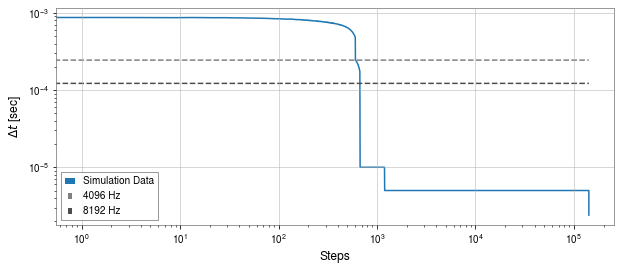

In [6]:
# Visualize the time steps

dts = np.diff(times_raw)
plt.figure(figsize=(10,4))
plt.loglog(dts, label="Simulation Data")
plt.loglog(np.ones(len(dts))/4096,'--',c="0.5",label="4096 Hz")
plt.loglog(np.ones(len(dts))/8192,'--',c="0.3",label="8192 Hz")
plt.ylabel(r"$\Delta t$ [sec]")
plt.xlabel("Steps")
plt.legend(loc="lower left")
plt.show()

Since the timesteps in CCSN simulation are not uniform, we need to resample the waveform with uniform timesteps.\
Note that the actual timestep is about $\Delta t \sim 10^{-6}$ sec. Linear interpolation should be enough if the sampling rate is about 4096-8192 Hz.

In [7]:
def resample(tt,hh,tstart,tend, sample_rate=8192):
    """
    tt : time array
    hh : strain array

    tstart : the starting time in second
    tend   : the end time in second

    sample_rate : sampling rate in Hz

    """ 
    f = interp1d(tt,hh) # linear interpolation
    num_sample = int((tend-tstart)*sample_rate)
    tt_resampled = np.linspace(tstart,tend, num_sample)
    hh_resampled = np.array([f(t) for t in tt_resampled])
    return tt_resampled, hh_resampled

In [8]:
# resample the waveform
times, strain = resample(times_raw,strain_raw, tstart= -0.1, tend=times_raw[-1], sample_rate=8192)

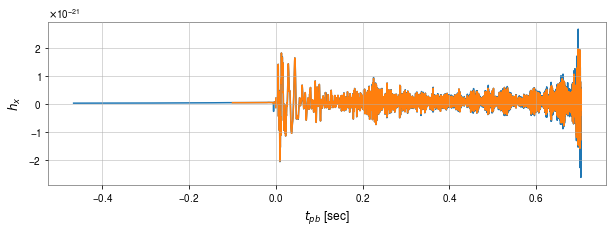

In [9]:
# Double checked the re-sampled waveform
plt.figure(2,figsize=(10,3))
plt.plot(times_raw, strain_raw)
plt.plot(times, strain)
plt.xlabel(r"$t_{pb}$ [sec]")
plt.ylabel(r"$h_x$")
#plt.xlim([-0.02,0.15])
plt.show()

Once we have the CCSN waveform, we could use `gwpy` to convert our simulated waveform into the `TimeSeries` data format.

In [10]:
ccsn_data = TimeSeries(strain,times=times, name="s402d (LS220)")

### Plotting time-dormain data

/home/jerry/miniconda3/envs/igwn-py39/lib/python3.9/site-packages/gwpy/plot/plot.py:279: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


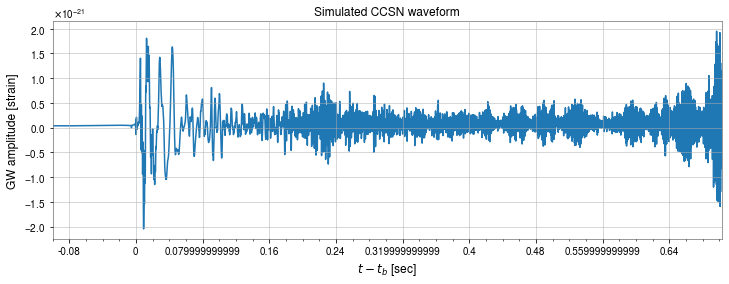

In [11]:
plot = ccsn_data.plot()
ax = plot.gca()
ax.set_xlabel(r"$ t - t_b$ [sec]")
ax.set_ylabel('GW amplitude [strain]')
ax.set_title('Simulated CCSN waveform')
plot.show()

### Plotting in frequency domain

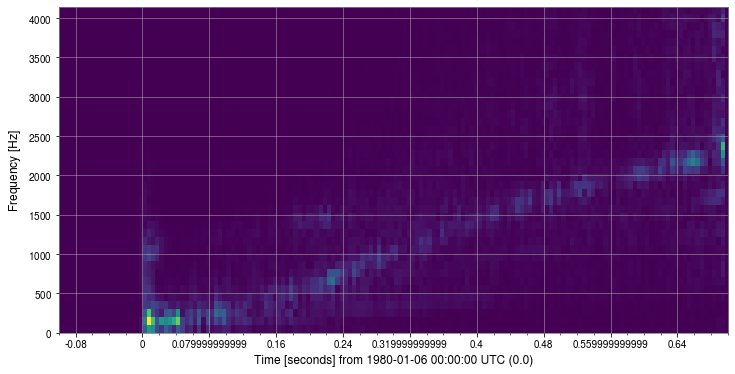

In [12]:
specgram = ccsn_data.spectrogram2(fftlength=0.01, overlap=0.005, window='hann') ** (1/2.)
plot = specgram.plot()

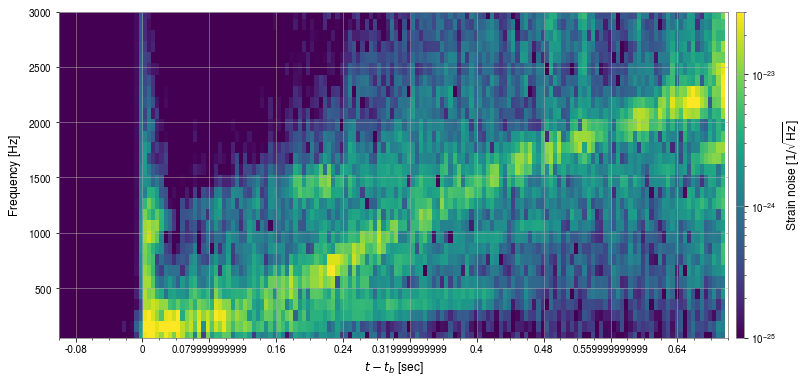

In [13]:
ax = plot.gca()
#ax.set_yscale('log')
ax.set_ylim(50, 3000)
ax.set_xlabel(r"$ t - t_b$ [sec]")
ax.colorbar(
    clim=(1e-25, 3e-23),
    norm="log",
    label=r"Strain noise [$1/\sqrt{\mathrm{Hz}}$]",
)
plot  # refresh

## Playgound

1. Visualize different waveforms. What are there main differences?
2. Could you find the special GW signatures from rotating CCSNe?
3. Could you find the SASI signals?

In [ ]:
# TODO














---

## Generating the sound of CCSN waveforms

load the waveform data (again)

In [ ]:
file_name = "./Data_GW/data_s40_2d_LS220_d2_CrossEquator.d"
db = np.loadtxt(file_name, unpack=True)
times_raw  = db[0] # the raw time series
strain_raw = db[1] # the raw strains

# resample the waveform
times, strain = resample(times_raw,strain_raw, tstart= -0.1, tend=times_raw[-1], sample_rate=8192)

In [ ]:
def generate_gw_sound(times, strain, name):
    output_name = name+'.mp3'
    data = strain * 1.e21
    nsample = int(len(data)/(times[-1]- times[0]))
    # keep the data within integer limits, and write to wavfile:
    d = np.int16(data/max(np.abs(data)) * 32767 * 0.9)
    wavfile.write(output_name,nsample, d)
    return

In [ ]:
generate_gw_sound(times,strain,"s40_2d_LS220")

### Playground

Now, you could try generating the GW sounds with other CCSN waveforms (or merger waveforms).

In [ ]:
# TODO














